In [ ]:
!pip install sewar
import cv2
import numpy as np
import random
#from sklearn.metrics import mean_squared_error as mse
from PIL import ImageChops, Image
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import color
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import log10, sqrt 
import skimage 
from skimage import filters
import math 
from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import vifp
from skimage import io
from google.colab.patches import cv2_imshow

from itertools import combinations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=e421656e119a5547e64231a279384dc451a51fba32830795c2ab31b679f060ba
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#https://github.com/kartikeyaGUPTA45/KAPUR-S-ENTROPY/blob/master/KAPUR'S_ENTROPY.ipynb
def kapur_entropy(h,thresholds,nthrs):
  #COUNTING PIXELS
  cnt = 0
  for i in range(0, len(h)):
    if h[i]>0:
           cnt += h[i]
           
  #FINDING PROBABILITY OF AN INDIVIDUAL PIXEL
  prob=[]
  for i in range (len(h)):
    h[i]=h[i]/cnt
    prob.append(h[i])

  '''KAPUR'S ENTROPY CALCULATION. REFER - https://docs.google.com/document/d/1Rx0Gk9gb65ZSZAmPaSj2c75te8yuxjCPl1PXps1yLdk/edit '''
  ###sum of intensity values for each segment created by threshold MARKED IN PURPLE
  SUM=[]
  SUM.append(sum(h[0:thresholds[0]]))
  
  for i in range(len(thresholds)-1):
    SUM.append(sum(h[thresholds[i]:thresholds[i+1]]))

  SUM.append(sum(h[thresholds[nthrs-1]:256]))  

  #### CALCULATING WO AS MARKED IN BLUE FOR EACH SEGMENT CREATED BY THE THRESHOLDS
  w0=prob[:]
  for k in range(len(thresholds)):
    if(k==0):
      for i in range(0,thresholds[k]):
        w0[i]=w0[i]/SUM[k]
    if(k==len(thresholds)):
      for i in range(thresholds[k-1],256):
        w0[i]=w0[i]/SUM[k]
    else:
      for i in range(thresholds[k-1],thresholds[k]):
        w0[i]=w0[i]/SUM[k]

  ### CALCULATING W1 AS MARKED IN RED FOR EACH SEGMENT CREATED BY THE THRESHOLDS
  w1=prob[:]
  for k in range(len(thresholds)):
    if(k==0):
      for i in range(0,thresholds[k]):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(w1[i]/SUM[k])
    if(k==len(thresholds)):
      for i in range(thresholds[k-1],256):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(w1[i]/SUM[k])
    else:
      for i in range(thresholds[k-1],thresholds[k]):
        if w1[i]==0:
          w1[i]=w1[i]
        else:
          w1[i]=math.log(abs(w1[i]/SUM[k]))

  ###MULTIPLYING W0 AND W1 AS IN THE FORMULAE
  mul=[]
  for i in range(len(w0)):
    mul.append(w0[i]*w1[i])

  ### GETTING THE SUM OF THE ABOVE MULTIPLIED QUANTITY FOR EACH SEGMENT
  kapur_entropy=[]
  for i in range(len(thresholds)-1):
    kapur_entropy.append(-(sum(mul[thresholds[i]:thresholds[i+1]])))

  #OBJECTIVE FUNCTION 
  J=sum(kapur_entropy)
  #print(J)

  return (J)

In [ ]:
def _get_thresholds(hist, nthrs):
    """Get the thresholds that maximize the entropy of the regions
    @param hist: The normalized histogram of the image                 @type hist: ndarray
    @param c_hist: The cummuative normalized histogram of the image    @type c_hist: ndarray
    @param nthrs: The number of thresholds                             @type nthrs: int  """

    # Thresholds combinations
    thr_combinations = combinations(range(255), nthrs)

    max_entropy = 0
    opt_thresholds = None

    for thresholds in thr_combinations:
        # Extending thresholds for convenience
        e_thresholds = [-1]
        e_thresholds.extend(thresholds)
        e_thresholds.extend([len(hist) - 1])

        regions_entropy = kapur_entropy(hist, e_thresholds,nthrs)

        if regions_entropy > max_entropy:
            max_entropy = regions_entropy
            opt_thresholds = thresholds
    return opt_thresholds

In [ ]:
def kapur_multithreshold(image, nthrs):
    """ Runs the Kapur's multi-threshold algorithm.
    @param image: The input image               @type image: ndarray
    @param nthrs: The number of thresholds      @type nthrs: int
    @return: The estimated threshold            @rtype: int
    """
    # Histogran
    hist, _ = np.histogram(image, bins=range(256), density=True)

    # Cumulative histogram
    #c_hist = hist.cumsum()

    #return _get_thresholds(hist, c_hist, nthrs)
    return _get_thresholds(hist, nthrs)

def objective(sol,greyscale_img,uniq,region):
        
    out=np.zeros(shape=([len(greyscale_img),len(greyscale_img[0])]))
           
        
    for it in range(0,len(uniq)): # creation of new image
        for j in range(len(region[it][0])):
            out[region[it][0][j]][region[it][1][j]]=sol[it]
                    
    nthrs = 3
    opt_thresholds = kapur_multithreshold(out, nthrs)
    return(opt_thresholds)

In [ ]:
def fitness(sol,greyscale_img,uniq,region):
    #value=objective(sol,greyscale_img,uniq,region)
    value=kapur_entropy(greyscale_img)
    print(value)
    return value[0]

def distance(a,b,dim):
    o = np.zeros(dim)
    for i in range(0,len(a)):
        o[i] = abs(a[i] - b[i])
    return o

def Levy(d):
    beta=3/2
    sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
    u=np.random.randn(d)*sigma
    v=np.random.randn(d)
    step=u/abs(v)**(1/beta)
    o=0.01*step
    return o        

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal. # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

psnr=np.zeros(1)
vif=np.zeros(1) #Visual information fidelity
ssim_val=np.zeros(1) #Structural Similarity Index
img_list=[1]

Only dragonfly

In [ ]:
sr='/content/drive/MyDrive/Dataset/lena_colour01.png'  
source = cv2.imread(sr,0)
nthrs = 4
kapur_multithreshold(source, nthrs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Image No. 1


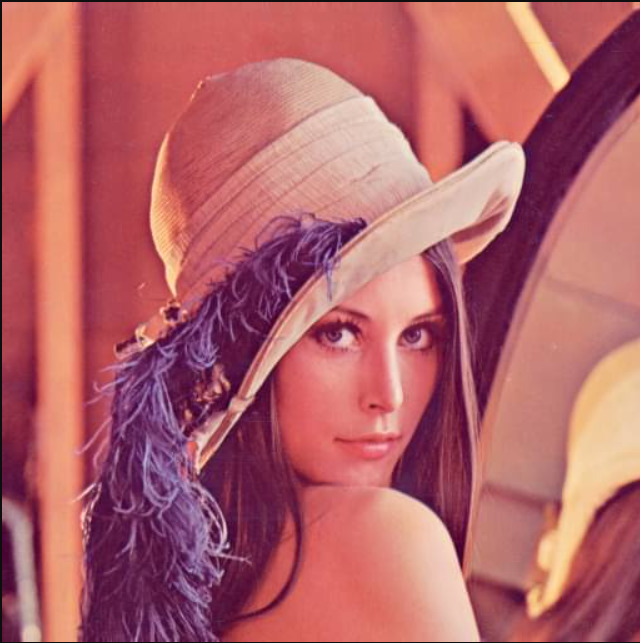

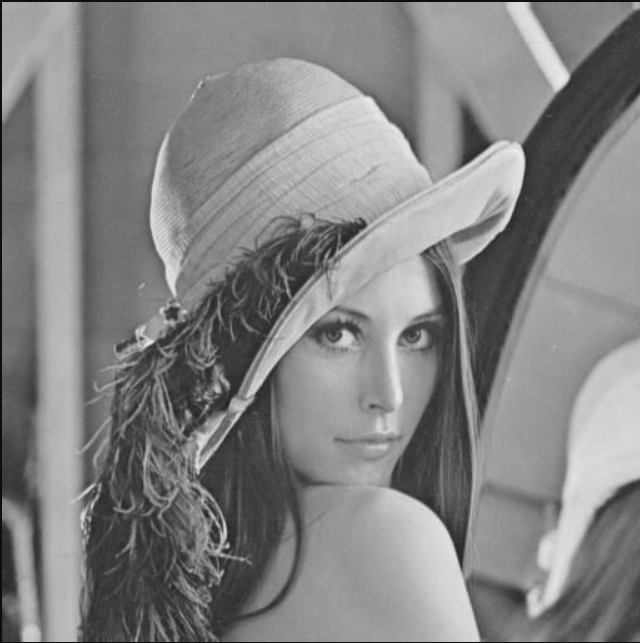

3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Streaming output truncated to the last 5000 lines.
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368
3.0864611204969368

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars


Streaming output truncated to the last 5000 lines.
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.0005501402389185245
-0.000

In [ ]:
'''for img_no in img_list:
    print("Image No. " + str(img_no))
    sr='/content/drive/MyDrive/Dataset/lena_colour' + str(img_no).zfill(2) + '.png'  # original image from kodak dataset
    source = cv2.imread(sr)
    cv2_imshow(source) #original image

    greyscale_img = cv2.imread(sr,0)
    cv2_imshow(greyscale_img) #grayscale image

    gr = cv2.imread(sr,0)

    #uniq=np.unique(greyscale_img)
    uniq=np.histogram(greyscale_img.ravel(),255,[0,256])[0]
    uniq=np.sort(uniq)
    
    dim=len(uniq)
    region=[]
    
    for i in uniq:
        reg=np.where(greyscale_img==i)
        region.append(reg)
    
    ### Parameters

    ub=255
    lb=0
    
    r=(ub-lb)/10
    Delta_max=(ub-lb)/8.5
    
    Food_fitness=0
    Food_pos=np.zeros(dim) #food position
    
    Enemy_fitness=math.inf
    Enemy_pos=np.zeros(dim) #enemy position
    
    population_size=5
    
    fitness_of_X = np.zeros(population_size)
    All_fitness = np.zeros(population_size)

    ### Parameter end 
    
    X = np.zeros(shape=(population_size,dim))
    DeltaX = np.zeros(shape=(population_size,dim))
    
    for i in range(0,population_size):
        for j in range(0,dim):
            X[i][j]=int(lb + random.uniform(0,1)*(ub-lb))
        
        X[i] = np.sort(X[i])
    
    i1=random.randint(0,population_size-1)
    i2=random.randint(0,population_size-1)
    
    #ub_del=25
    ub_del=50
    
    for i in range(0,population_size):
        for j in range(0,dim):
            DeltaX[i][j]=int(lb + random.uniform(0,1)*(ub_del-lb))
        
    #Max_iteration=10
    Max_iteration=1
    X= X.astype(int)
    for itr in range(1,Max_iteration+1):
        
        r=(ub_del-lb)/4+((ub_del-lb)*(itr/Max_iteration)*2)
        w=0.9-itr*((0.9-0.4)/Max_iteration)
        my_c=0.1-itr*((0.1-0)/(Max_iteration/2))
        
        if my_c<0:
            my_c=0
        
        s=2*random.random()*my_c #separation
        a=2*random.random()*my_c #alignment
        c=2*random.random()*my_c #cohesion
        f=2*random.random()*my_c 
        e=my_c 
        #j=0 
        for i in range(0,population_size):
            fitness_of_X[i] = fitness(X[i],greyscale_img,uniq,region)
            All_fitness[i] = fitness_of_X[i]
            
            if fitness_of_X[i] > Food_fitness:
                Food_fitness = fitness_of_X[i]
                #print(Food_fitness)
                Food_pos=X[i]
            
            if fitness_of_X[i] < Enemy_fitness:
                if all((X[i] <= ub)) and all((X[i] >= lb)):
                    #Enemy_fitness = fitness_of_X[i]
                    Enemy_fitness = Food_fitness
                    Enemy_pos = X[i]

            j=j+1
                    
        for i in range(0,population_size):
            index=0
            neighbours_no=0
            
            ### Neighbours position updation
            Neighbours_X = np.zeros(shape=(population_size,dim))
            Neighbours_DeltaX = np.zeros(shape=(population_size,dim))
            
            for j in range(0,population_size):
                Dist2Enemy = distance(X[i],X[j],dim)
                if (all(Dist2Enemy<=r) and all(Dist2Enemy!=0)):
                    index=index+1
                    neighbours_no=neighbours_no+1
                    Neighbours_DeltaX[index]=DeltaX[j]
                    Neighbours_X[index]=X[j]
                    
            #updation of separation cohesion and alignment
            S=np.zeros(dim)           
            if neighbours_no>1:
                for k in range(0,neighbours_no):
                    S=S+(Neighbours_X[k]-X[i])
                S=-S
            else:
                S=np.zeros(dim)
  
            if neighbours_no>1:
                A=(sum(Neighbours_DeltaX))/neighbours_no
            else:
                A = DeltaX[i]
            
            if neighbours_no>1:
                C_temp=(sum(Neighbours_X))/neighbours_no
            else:
                C_temp=X[i]
        
            C=C_temp-X[i]
            
            ###  distance from Food
            Dist2Food=distance(X[i],Food_pos,dim)
                               
            if all(Dist2Food<=r):
                F=Food_pos-X[i]
            else:
                F=np.zeros(dim)

            ### Distance from enemy
            Dist2Enemy=distance(X[i],Enemy_pos,dim)
                               
            if all(Dist2Enemy<=r):
                Enemy=Enemy_pos-X[i]
            else:
                Enemy=np.zeros(dim)

            ### updation of dragonfly position
            for tt in range(0,dim):
                if X[i][tt]>ub:
                    X[i][tt]=ub
                    DeltaX[i][tt]=random.uniform(0,1)*(50-lb)
                    
                if X[i][tt]<lb:
                    X[i][tt]=lb
                    DeltaX[i][tt]=random.uniform(0,1)*(50-lb)
            
            temp=np.zeros(dim)
            Delta_temp=np.zeros(dim)
            
            ### formula in the paper
            if any(Dist2Food>r):
                if neighbours_no>1:
                    for j in range(0,dim):
                        Delta_temp[j] = int(w*DeltaX[i][j] + random.random()*A[j] + random.random()*C[j] + random.random()*S[j])
                        if Delta_temp[j]>Delta_max:
                            Delta_temp[j]=Delta_max
                        if Delta_temp[j]<-Delta_max:
                            Delta_temp[j]=-Delta_max
                        temp[j]=X[i][j]+(Delta_temp[j])
                else:
                    temp=(X[i] + (Levy(dim))*X[i]).astype(int)
                    Delta_temp=np.zeros(dim)
            
            else:
                for j in range(0,dim):
                    Delta_temp[j] = int((a*A[j] + c*C[j] + s*S[j] + f*F[j] + e*Enemy[j]) + w*DeltaX[i][j]) 
                    if Delta_temp[j]>Delta_max:
                        Delta_temp[j]=Delta_max
                    if Delta_temp[j]<-Delta_max:
                        Delta_temp[j]=-Delta_max
                    temp[j]=X[i][j]+Delta_temp[j]

            ### checking the range  
            for j in range(0,dim):
                if temp[j]<lb: # Bringinging back to search space
                        temp[j]=lb
                    
                if temp[j]>ub: # Bringinging back to search space
                    temp[j]=ub
            temp=np.sort(temp)
            Delta_temp=np.sort(Delta_temp)
            if(fitness(temp,greyscale_img,uniq,region)) > fitness_of_X[i]:
                X[i]=temp
                DeltaX[i]=Delta_temp
                             
        Best_score=Food_fitness
        Best_pos=Food_pos
        
        print("Iteration = " + str(itr))
    
    best_sol=Best_pos
     
    for it in range(0,len(uniq)): # creation of new image
        for j in range(len(region[it][0])):
            gr[region[it][0][j]][region[it][1][j]]=best_sol[it]
                   
    res='/content/drive/MyDrive/output/' + str(img_no).zfill(2)  # folder containing the output'''

    '''#### before DA results
    print(' before DA results \n **********************')
    cv2.imwrite(res + '/before.jpg', greyscale_img)
    cv2_imshow(greyscale_img)

    ax = plt.hist(greyscale_img.ravel(), 256,[0,256])
    fig1 = plt.gcf()
    plt.show()
    plt.draw()'''

    '''#### after DA results
    print(' after DA results \n **********************')
    cv2.imwrite(res + '/after.jpg', gr)
    cv2_imshow(gr)

    ax = plt.hist(gr.ravel(), 256, [0,256])
    fig2 = plt.gcf()
    plt.show()
    plt.draw()

    
    print('\n **********************\n')

    vif[img_no -1]=vifp(source[:,:,1], greyscale_img)
    psnr[img_no -1]=PSNR(source[:,:,1],gr)
    ssim_val[img_no -1]=ssim(source[:,:,1], gr)
    
    print("psnr = "+str(psnr[img_no -1]))
    print("vif = "+str(vif[img_no -1]))
    print("ssim = "+str(ssim_val[img_no -1]))'''